# Build a video generation pipeline with SageMaker and BedRock

In this notebook, we demonstrate how to leverage BedRock API and SageMaker endpoint to generate a video with a text prompt and a given video.

## Generate a image with textual prompt via BedRock API

In [16]:
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
from PIL import Image
import botocore

boto3_bedrock = boto3.client('bedrock-runtime')

In [95]:
prompt = "a human's face"
negative_prompts = [
    "poorly rendered",
    "background"
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

In [96]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 42,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAACvmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


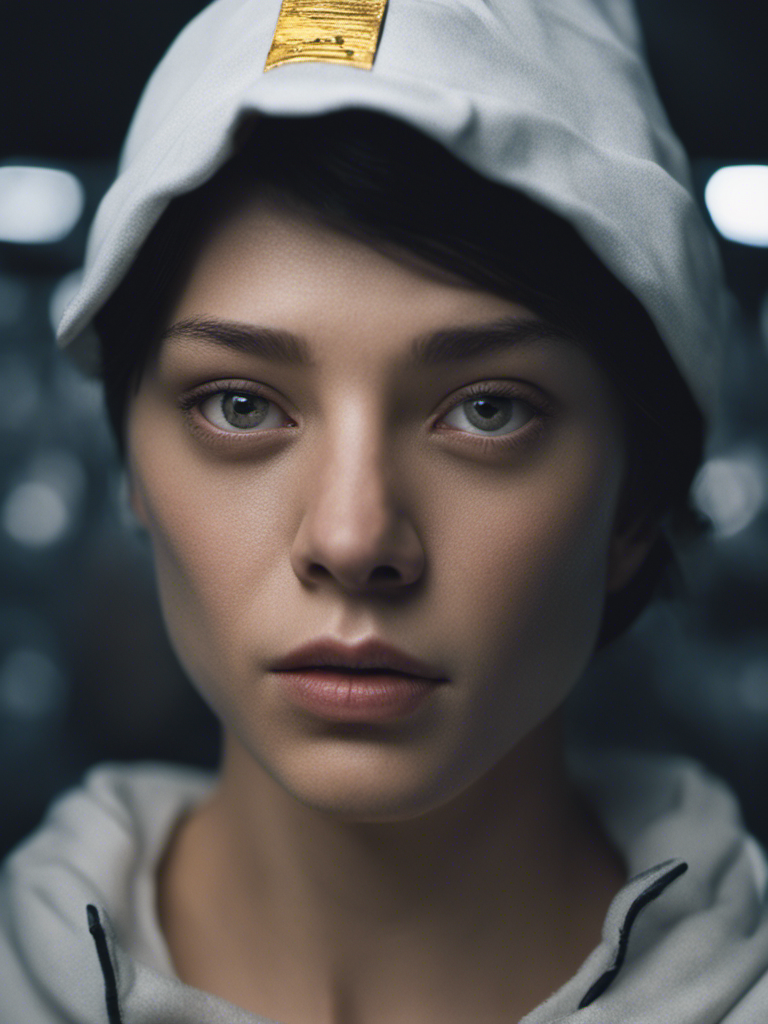

In [97]:
os.makedirs("data", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
reference_img_path = "data/image_1.png"
image_1.save(reference_img_path)
image_1

## Generate a pose sequence from a video
you can use the generated pose sequence generated in [inference-byoc-dwpose.ipynb](./inference-byoc-dwpose.ipynb), or you can generate a pose sequence on the new video.

In [5]:
%%bash
pip install opencv-python
pip install av
pip install torch
pip install torchvision
pip install einops

In [6]:
from dwpose_inference import extract_dwpose
import os

data_path = "./Moore-AnimateAnyone/configs/inference/talkinghead_videos/1.mp4"
save_dir = "datasets/"

endpoint_name = "dwpose-20240723-073243-endpoint"

file_name = os.path.basename(data_path)
file_dir = os.path.dirname(data_path)
file_name = file_name if file_dir != save_dir else f'gen_{file_name}'
file_path = os.path.join(save_dir, file_name)

extract_dwpose(data_path, endpoint_name, file_path)

Processing frames: 100%|██████████| 299/299 [00:17<00:00, 16.65it/s, Frame=299, Processing time=0.05s]


In [7]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for 

In [8]:
from IPython.display import HTML

video_html = f"""
<video width="640" height="480" controls>
  <source src="{file_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""
HTML(video_html)

## Generate video with the reference image and the pose sequence generated above

Prepare the input dataset

In [98]:
import sagemaker
import boto3
from botocore.exceptions import NoCredentialsError

def upload_to_s3(local_file, bucket, s3_file):
    s3 = boto3.client('s3')

    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False

sess = sagemaker.session.Session()
model_bucket = sess.default_bucket() 

s3_prefix = "animateanyone_inference"

pose_s3_path = f"s3://{model_bucket}/{s3_prefix}/inputs/face_smile_dwpose.mp4"
ref_s3_path = f"s3://{model_bucket}/{s3_prefix}/inputs/face_smile.png"
input_async_s3_path = f"s3://{model_bucket}/{s3_prefix}/inputs/input_data_async.json"
output_s3uri = f"s3://{model_bucket}/{s3_prefix}/outputs/anyone-video-1.mp4"

input_data_async = {
    "pose_seq_s3uri": pose_s3_path,
    "ref_s3_path": ref_s3_path,
    'height': 512,
    'width': 512,
    'steps': 30,
    'cfg': 3.5,
    'fps': -1,
    'seed': 42,
    'length': 30,
    'output_s3uri': output_s3uri
}

input_async_path = "./input_data_async.json"
with open(input_async_path, 'w') as file:
    json.dump(input_data_async, file)
    
pose_s3uri = f"{s3_prefix}/inputs/face_smile_dwpose.mp4s"
ref_s3uri = f"{s3_prefix}/inputs/face_smile.png"
input_s3uri = f"{s3_prefix}/inputs/input_data_async.json"

upload_to_s3(file_path, model_bucket, pose_s3uri)
upload_to_s3(reference_img_path, model_bucket, ref_s3uri)
upload_to_s3(input_async_path, model_bucket, input_s3uri)

Upload Successful
Upload Successful
Upload Successful


True

In [99]:
sm_runtime = boto3.Session().client("sagemaker-runtime")
endpoint_name = "endpoint-20240723-072940animateanyone"

response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_async_s3_path,
    InvocationTimeoutSeconds=3600
)
output_location = response['OutputLocation']

In [100]:
from botocore.exceptions import ClientError
import urllib
import sys
import time

timeout = 1200

def get_output(output_location, timeout=1200):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    start_time = time.time()
    while True:
        try:
            return sess.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                print("waiting for output...")
                time.sleep(2)
                if time.time() - start_time > timeout:
                    raise Exception("timeout!!!")
                    break
                continue
            raise

In [101]:
output = get_output(output_location)
print(f"Output size in bytes: {((sys.getsizeof(output)))}")

waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting fo

In [ ]:
!aws s3 cp $output_s3uri generated_res.mp4

In [103]:
from IPython.display import HTML

video_path = "generated_res.mp4"

video_html = f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""
HTML(video_html)